# Load Data

## Imports & Setup

In [1]:
#import datetime
from pathlib import Path

#import joblib
import matplotlib.pyplot as plt
#import midi
import numpy as np
import pandas as pd

from IPython.display import Audio

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import LSTM, Activation, CuDNNLSTM, Dense, Dropout, SimpleRNN, CuDNNGRU
from keras.models import Sequential
from keras.utils import normalize, to_categorical
from keras.optimizers import Adam

from music21 import chord, converter, instrument, note, stream

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler

from musicnet import data_utils, mn_utils, params

from intervaltree import Interval, IntervalTree
from tqdm import tqdm

pd.options.display.max_columns = 500
pd.options.display.max_rows = 50

plt.style.use('dark_background')

%matplotlib inline
        
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load and inspect Musicnet metadata

In [2]:
metadata = mn_utils.get_musicnet_metadata()

In [3]:
metadata.head()

,composer,composition,movement,ensemble,source,transcriber,catalog_name,seconds
id,,,,,,,,
1727,Schubert,Piano Quintet in A major,2. Andante,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,447
1728,Schubert,Piano Quintet in A major,3. Scherzo: Presto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,251
1729,Schubert,Piano Quintet in A major,4. Andantino - Allegretto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,444
1730,Schubert,Piano Quintet in A major,5. Allegro giusto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,368
1733,Schubert,Piano Sonata in A major,2. Andantino,Solo Piano,Museopen,Segundo G. Yogore,D959,546


## Load and inspect MIDI GM mapping data

In [4]:
gm_map = data_utils.get_midi_gm_mapping()

midi_gm_mapping = {}
for i in range(128):
    midi_gm_mapping[gm_map.patch_number[i]] = gm_map.instrument_name[i]

## Load and inspect Musicnet data

In [5]:
sample_rate = params.sample_rate
resolution = params.resolution
data = mn_utils.load_musicnet_data()

### Inspect a random sample

In [6]:
sample = np.random.choice(list(data.keys()), 1)[0]
sample = '2105'
X, Y = data[sample]
data_utils.to_hms(len(X) / sample_rate)

'0:04:52'

In [7]:
instruments = mn_utils.get_instrument_list(Y)

for inst in instruments:
    print(str(inst).zfill(3), midi_gm_mapping[inst])

041 Violin
042 Viola
043 Cello


Haydn - Quartet No 53 in D major - Movement 2. Adagio - Cantabile


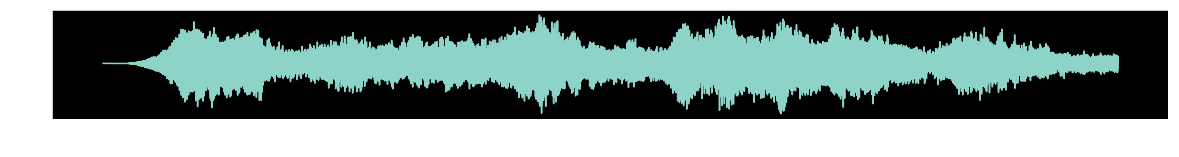

In [8]:
info = metadata.loc[int(sample), :]
print(info.composer, '-', info.composition, '- Movement', info.movement)

mn_utils.plot_recording(X, seconds=10)

Audio(X[0:10 * sample_rate], rate=sample_rate)

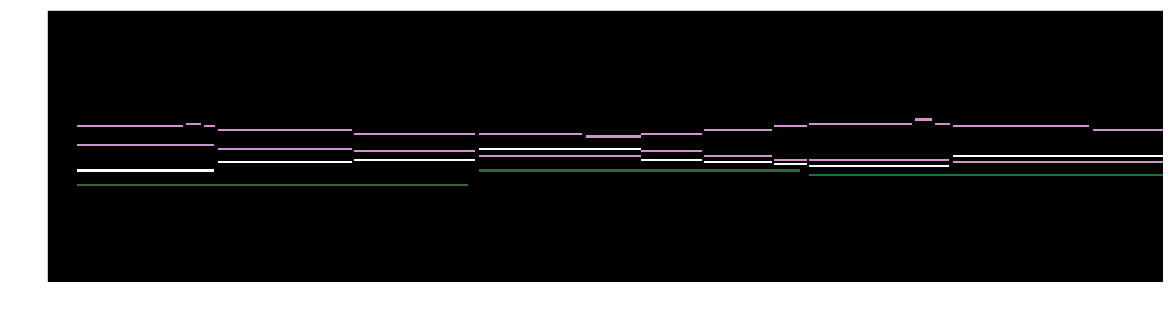

In [9]:
mn_utils.plot_piano_roll(X, Y, seconds=10, darkmode=True)

### Structure of MusicNet label data

In [10]:
(start_time, end_time, (instrument_, note_, measure_, beat_, note_value_)) = sorted(Y[sample_rate * 3])[0]

print('Start Time: ' + str(start_time))
print('  End Time: ' + str(end_time))
print('Instrument: ' + str(instrument_))
print('      Note: ' + str(note_))
print('   Measure: ' + str(measure_))
print('      Beat: ' + str(beat_))
print('Note Value: ' + str(note_value_))

Start Time: 11742
  End Time: 166366
Instrument: 43
      Note: 45
   Measure: 2
      Beat: 2.220446049250313e-16
Note Value: Dotted Half


## Load flattened label data (from pandas pickle)

In [11]:
comp_df = pd.read_pickle('data/interim/label_data.pandas_pickle')

In [12]:
comp_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2178860 entries, 510245 to 1743790
Data columns (total 11 columns):
comp            category
start           int64
end             int64
instrument      int64
note            int64
measure         int64
beat            float64
note_value      category
event           category
event_sample    int64
tick            int64
dtypes: category(3), float64(1), int64(7)
memory usage: 157.9 MB


In [13]:
comp_df.head()

,comp,start,end,instrument,note,measure,beat,note_value,event,event_sample,tick
510245,1727,9182,62430,1,69,2,0.000000,Quarter,note_on,9182,208
510246,1727,9182,62430,1,81,2,0.000000,Quarter,note_on,9182,0
510251,1727,62430,119774,1,72,2,0.333333,Quarter,note_on,62430,1207
510252,1727,62430,119774,1,84,2,0.333333,Quarter,note_on,62430,0
1599675,1727,9182,62430,1,69,2,0.000000,Quarter,note_off,62430,0


In [14]:
comp_df.note.min(), comp_df.note.max()

(21, 104)

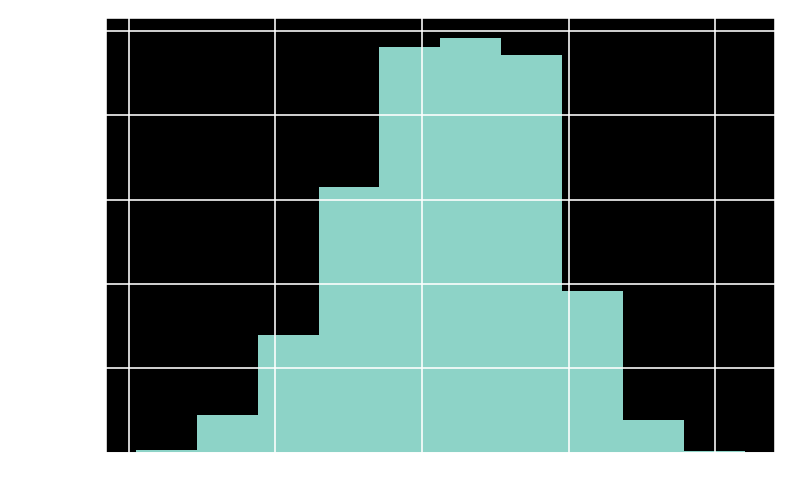

In [15]:
comp_df.note.hist();

In [16]:
comp_df.note_value.value_counts()

Eighth                        601848
Sixteenth                     519972
Quarter                       259306
Triplet Sixteenth             122806
Dotted Eighth                 119962
Thirty Second                 109494
Triplet                       107904
Dotted Sixteenth               84760
Half                           71722
Dotted Quarter                 42568
Triplet Thirty Second          37418
Dotted Half                    28234
Triplet Sixty Fourth           18724
Sixty Fourth                   16920
Tied Quarter-Sixteenth         13862
Whole                          12098
Unknown                         9204
Tied Quarter-Thirty Second      2058
Name: note_value, dtype: int64

In [17]:
note_filter_min = 48
note_filter_max = 71
note_value_filter = [
    'Eighth',
    'Sixteenth',
    'Quarter',
    'Half'    
]

In [76]:
p = Path('data/midi_samples/')

In [92]:
sum(a.stat().st_size for a in p.rglob('*.mid'))

443130

In [89]:
a.stat().st_size

8480

# Prepare Data

## Sample properties

In [18]:
raw_data = pd.read_pickle('data/interim/element_data_sample.pandas_pickle')

In [25]:
sp_note = raw_data.iloc[7, 2]
sp_rest = raw_data.iloc[8, 2]
sp_chrd = raw_data.iloc[2044, 2]

### Rest properties

In [73]:
sp_rest

<music21.note.Rest rest>

In [26]:
sp_rest.duration.type, sp_rest.duration.fullName, sp_rest.duration.components[0]

('quarter',
 'Quarter',
 DurationTuple(type='quarter', dots=0, quarterLength=1.0))

### Note properties

In [69]:
sp_note.volume.velocity

110

In [28]:
sp_note.nameWithOctave

'B-4'

In [29]:
sp_note.pitch.midi

70

In [30]:
sp_note.duration.type, sp_note.duration.fullName, sp_note.duration.components[0]

('quarter',
 'Quarter',
 DurationTuple(type='quarter', dots=0, quarterLength=1.0))

### Chord properties

In [70]:
sp_chrd.volume.velocity

86

In [48]:
sp_chrd.pitchedCommonName

'A3-major triad'

In [49]:
sp_chrd.pitchClasses

[9, 1, 4]

In [50]:
' '.join([str(p) for p in sp_chrd.pitchClasses])

'9 1 4'

In [51]:
sp_chrd.pitches

(<music21.pitch.Pitch A3>, <music21.pitch.Pitch C#4>, <music21.pitch.Pitch E4>)

In [52]:
' '.join([str(p.midi) for p in sp_chrd.pitches])

'57 61 64'

In [53]:
sp_chrd.fullName

'Chord {A in octave 3 | C-sharp in octave 4 | E in octave 4} Dotted Eighth'

In [54]:
sp_chrd.pitchedCommonName

'A3-major triad'

In [55]:
sp_chrd.duration.type, sp_chrd.duration.fullName, sp_chrd.duration.components[0]

('eighth',
 'Dotted Eighth',
 DurationTuple(type='eighth', dots=1, quarterLength=0.75))

## Preprocess

In [18]:
%%time
ed = pd.read_pickle('data/interim/element_data_processed.pandas_pickle')

CPU times: user 3.69 ms, sys: 0 ns, total: 3.69 ms
Wall time: 3.12 ms


# Old stuff

In [19]:
ed['part'].value_counts()

Piano          138215
Viola           59028
Violin          53107
Violoncello     50791
Bassoon          8379
Clarinet         7079
Horn             5812
Harpsichord      1799
Oboe             1740
Flute             848
Contrabass        505
Name: part, dtype: int64

In [20]:
data_vio = ed[ed['part'].str.startswith('Vio')].copy()

In [45]:
data = ed[['comp', 'part', 'note_class']].copy()

In [46]:
classes = data['note_class']

# get all pitch names
pitchnames = sorted(set(item for item in classes))
 # create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [47]:
data['note'] = data['note_class'].map(note_to_int)
data = data[['comp', 'part', 'note']]

In [48]:
%%time
seq_size = 100

columns = ['comp', 'part', 'note'] + ['note_' + str(i).zfill(3) for i in range(1, seq_size + 1)]
data_seq = pd.DataFrame(columns=columns)

total_comps = data['comp'].nunique()

for i, comp in enumerate(data['comp'].unique()):
    
    lagged_df_comp = data[data['comp'] == comp].copy()
            
    for part in lagged_df_comp['part'].unique():
        
        lagged_df_part = lagged_df_comp[lagged_df_comp['part'] == part].copy()
            
        for lag in range(1, seq_size + 1):
            lagged_df_part['note_' + str(lag).zfill(3)] = lagged_df_part['note'].shift(lag)
        
        data_seq = data_seq.append(lagged_df_part, sort=True)
    
    if i % 50 == 0:
        print('Processed', i + 1, 'items')
    
    if i == total_comps - 1:
        print('Processed all', i + 1, 'items.')        

Processed 1 items
Processed 51 items
Processed 101 items
Processed 151 items
Processed 201 items
Processed 251 items
Processed 301 items
Processed all 330 items.
CPU times: user 1min 39s, sys: 26.9 s, total: 2min 6s
Wall time: 1min 3s


In [49]:
data_seq = data_seq.drop(columns=['comp', 'part']).dropna()#.astype('int')
data_seq = data_seq[data_seq.columns.sort_values(ascending=False)]

In [50]:
X = data_seq.drop(columns=['note'])
y = data_seq['note']

In [51]:
norm = Normalizer()
scale = StandardScaler()
X = norm.fit_transform(X)

In [52]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [53]:
X_train = X.reshape((len(X), seq_size, 1))
#X_test = X_test.reshape((len(X_test), seq_size, 1))

#X_train = X_train / float(len(pitchnames))

y_train = to_categorical(y)
#y_test = to_categorical(y_test)

In [31]:
def djmodel(Tx, n_a, n_values):
    """
    Implement the model
    
    Arguments:
    Tx -- length of the sequence in a corpus
    n_a -- the number of activations used in our model
    n_values -- number of unique values in the music data 
    
    Returns:
    model -- a keras model with the 
    """
    
    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
    ### START CODE HERE ### 
    # Step 1: Create empty list to append the outputs while you iterate (≈1 line)
    outputs = []
    
    # Step 2: Loop
    for t in range(Tx):
        
        # Step 2.A: select the "t"th time step vector from X. 
        x = Lambda(lambda x: X[:,t,:])(X)
        # Step 2.B: Use reshapor to reshape x to be (1, n_values) (≈1 line)
        x = reshapor(x)
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [57]:
model = Sequential()

model.add(CuDNNLSTM(
    512,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    name='lstm_1_input'
))
model.add(Dense(len(pitchnames), name='dense_1'))
model.add(Activation('softmax', name='softmax_1'))
model.add(Dropout(0.25, name='dropout_1'))

model.add(CuDNNLSTM(512, return_sequences=True, name='lstm_2'))
model.add(Dense(len(pitchnames), name='dense_2'))
model.add(Activation('softmax', name='softmax_2'))
model.add(Dropout(0.25, name='dropout_2'))

model.add(CuDNNLSTM(128, return_sequences=False, name='lstm_6'))
model.add(Dense(len(pitchnames), name='dense_6'))
model.add(Activation('softmax', name='softmax_6'))
model.add(Dropout(0.25, name='dropout_6'))


opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (CuDNNLSTM)     (None, 100, 512)          1054720   
_________________________________________________________________
dense_1 (Dense)              (None, 100, 120)          61560     
_________________________________________________________________
softmax_1 (Activation)       (None, 100, 120)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 120)          0         
_________________________________________________________________
lstm_2 (CuDNNLSTM)           (None, 100, 512)          1298432   
_________________________________________________________________
dense_2 (Dense)              (None, 100, 120)          61560     
_________________________________________________________________
softmax_2 (Activation)       (None, 100, 120)          0         
__________

In [60]:
model = Sequential()

model.add(CuDNNLSTM(
    512,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    name='lstm_1_input'
))

model.add(Dropout(0.3))
model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(CuDNNLSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(len(pitchnames), name='dense_6'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# Load the weights to each node

In [61]:
filepath = 'weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5'

checkpoint = ModelCheckpoint(filepath, save_best_only=True)

earlystopping = EarlyStopping(patience=5)

log_dir = Path('./logs')
try:
    for log in log_dir.glob('events.out.*'):
        log.unlink()
    print('Previous logs cleared.')
except:
    print('Error cleaning previous logs.')

tensorboard = TensorBoard(log_dir=str(log_dir), update_freq=1000)
print('Log dir:', str(log_dir.absolute()))

callbacks_list = [checkpoint, earlystopping, tensorboard]

Previous logs cleared.
Log dir: /home/emredjan/stack/data/musicnet/logs


In [62]:
model.fit(X_train, y_train, epochs=200, batch_size=100, callbacks=callbacks_list, validation_split=0.33, verbose=1)

Train on 177367 samples, validate on 87360 samples
Epoch 1/200
 14400/177367 [=>............................] - ETA: 3:51 - loss: 4.4395 - acc: 0.0210

KeyboardInterrupt: 

In [81]:
model = Sequential()
model.add(CuDNNLSTM(
    256,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(CuDNNLSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(len(pitchnames)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.load_weights('weights.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_16 (CuDNNLSTM)    (None, 50, 256)           265216    
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 256)           0         
_________________________________________________________________
cu_dnnlstm_17 (CuDNNLSTM)    (None, 50, 256)           526336    
_________________________________________________________________
dropout_17 (Dropout)         (None, 50, 256)           0         
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 256)               526336    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
__________

In [175]:
start = np.random.randint(0, len(X_train) - 1)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = X_train[start]
prediction_output = []

In [176]:
# generate 500 notes
for note_index in range(100):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(len(pitchnames))
    
    prediction = model.predict(prediction_input, verbose=0)
    
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]

In [177]:
prediction_output

['D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - eighth',
 'D4 - e

# Build MIDI file

In [17]:
total_songs = len(data)

for i, s in enumerate(song_df.song.unique()):
    
    song = song_df[song_df.song == s]

    pattern = midi.Pattern(resolution=resolution)

    for ch, inst in enumerate(song.instrument.unique()):

        track = midi.Track()
        pattern.append(track)

        midi_inst = inst - 1
        track.append(midi.ProgramChangeEvent(tick=0, channel=ch, data=[midi_inst]))

        if 1 <= inst <= 10:
            track.append(midi.ControlChangeEvent(tick=1, channel=ch, data=[64, 127]))

        for row in song[song.instrument == inst].iterrows():
            tick = row[1]['tick']
            event = row[1]['event']
            note = row[1]['note']

            vel = int(np.clip(np.random.normal(loc=85, scale=20), 20, 127))

            if event == 'note_on':
                track.append(midi.NoteOnEvent(tick=tick, channel=ch, velocity=vel, pitch=note))
            elif event == 'note_off':
                track.append(midi.NoteOffEvent(tick=tick, channel=ch, pitch=note))

        if inst == 1:
            track.append(midi.ControlChangeEvent(tick=1, channel=ch, data=[64, 0]))

        track.append(midi.EndOfTrackEvent(tick=1))
    
    midi.write_midifile('temp/midi/' + s + '.mid', pattern)
    
    if i % 50 == 0:
        print('Processed', i + 1, 'items')
    
    if i == total_songs - 1:
        print('Processed all', i + 1, 'items.')

Processed 1 items
Processed 51 items
Processed 101 items
Processed 151 items
Processed 201 items
Processed 251 items
Processed 301 items
Processed all 330 items.


In [ ]:
pattern

In [24]:
midi.write_midifile('test.mid', pattern)

# Sample MIDI dump

In [103]:
midi_file = midi.read_midifile('data/midi/mozart_serenata_375_4_(c)icking-archive.mid')

In [ ]:
for track in midi_file[1:7]:
    print(track[:15])

In [12]:
x = m21.converter.parse('test.mid')

In [32]:
a = list(x[0].recurse())

In [83]:
def get_notes():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []

    file = 'temp/midi2/2677.mid'
    midi = m21.converter.parse(file)

    print("Parsing %s" % file)

    notes_to_parse = None

    try: # file has instrument parts
        s2 = m21.instrument.partitionByInstrument(midi)
        notes_to_parse = s2.parts[0].recurse() 
    except: # file has notes in a flat structure
        notes_to_parse = m21.midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, m21.note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, m21.chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

In [145]:
elements = []
songs = []
instruments = []
notes_to_parse = None

midi_file = Path('temp/midi/1728.mid')
midi_data = converter.parse(midi_file)

In [90]:
midi_parts = instrument.partitionByInstrument(midi_data)

try: # file has instrument parts
    
    notes_to_parse = s2.parts[0].recurse() 
except: # file has notes in a flat structure
    notes_to_parse = midi.flat.notes

for element in notes_to_parse:
    if isinstance(element, note.Note):
        notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))

In [146]:
midi_parts = instrument.partitionByInstrument(midi_data)

for part in midi_parts:
    
    part_contents = part.recurse()
    
    for element in part_contents:
        elements.append(element)
        instruments.append(part.id)
        songs.append(midi_file.stem)

In [149]:
len(elements)

3878

In [84]:
notes = get_notes()
# Get all pitch names
n_vocab = len(set(notes))
n_vocab

Parsing temp/midi2/2677.mid


125

In [177]:
#def prepare_sequences(notes, n_vocab):

sequence_length = 100

# get all pitch names
pitchnames = sorted(set(item for item in notes))

 # create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

In [183]:
n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)

network_output = to_categorical(network_output)

In [184]:
np.array(network_input).shape

(1055, 100, 1)